In [1]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dropout,Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import operator
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

Using TensorFlow backend.


# Parameters

In [2]:
#Tweakable
epochs = 3
batch_size = 16

#Constants
target_img_width, target_img_height = 224, 224
train_dir = '../../../dataset/split_data/train/'
val_dir = '../../../dataset/split_data/validation/'
test_dir = '../../../dataset/split_data/test/'
vgg_train_features_file = "vgg_train_features.npy"
vgg_val_features_file = "vgg_val_features.npy"
vgg_test_features_file = "vgg_test_features.npy"
num_classes = 10
top_model_weights_path = 'top_model_weights.h5'

# Extract feature-vectors from VGG16

In [3]:
def get_features(model, data_dir):
    #Create a generator to load the data
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    generator = datagen.flow_from_directory(data_dir, 
                                            target_size=(target_img_width, target_img_height),
                                            batch_size=batch_size, 
                                            class_mode=None, #only the data, without labels
                                            shuffle=False) #keep data ordered 
    #Extract information about the data
    num_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)
    
    #Obtain number of steps required
    steps = ceil(num_samples / batch_size)
    #print("steps %s" % steps)
    
    #Obtain the bottleneck features before the dense layers
    features = model.predict_generator(generator, steps=steps, verbose=1)
    return features

In [4]:
def extract_vgg16_features():
    #Load the VGG16 Model
    model = applications.VGG16(include_top=False, weights="imagenet")
    
    #-----------------TRAINING DATA------------------
    #Run the training data through vgg and obtain the corresponding features
    train_features = get_features(model, train_dir)                
    
    #Save the training features in a numpy file
    np.save(vgg_train_features_file, train_features)
    print("Saved Training Features in %s" % vgg_train_features_file)
    
    #-----------------VALIDATION DATA------------------
    #Run the validation data through vgg and obtain the corresponding features
    val_features = get_features(model, val_dir)                
    
    #Save the validation features in a numpy file
    np.save(vgg_val_features_file, val_features)
    print("Saved Validation Features in %s" % vgg_val_features_file)
    
    
    #-----------------TESTING DATA------------------
    #Run the testing data through vgg and obtain the corresponding features
    test_features = get_features(model, test_dir)                
    
    #Save the testing features in a numpy file
    np.save(vgg_test_features_file, test_features)
    print("Saved Testing Features in %s" % vgg_test_features_file)
    

# Top Model to be Retrained

In [5]:
def create_top_model(final_activation,input_shape):
    model = Sequential()  
    model.add(Flatten(input_shape=input_shape))  
    model.add(Dense(256, activation='relu'))  
    model.add(Dropout(0.5))  
    model.add(Dense(num_classes, activation=final_activation)) # sigmoid to train, softmax for prediction
    return model

In [6]:
def load_data_and_labels(features_file, data_dir):
    #Create the datagen
    datagen = ImageDataGenerator(rescale=1.0/255.0) 
        
    #Create the generator to load the data
    generator = datagen.flow_from_directory(data_dir, 
                                            target_size=(target_img_width, target_img_height),
                                            batch_size=batch_size,
                                            class_mode='categorical', #specify categorical
                                            shuffle=False #Data is ordered
                                           )
    #Obtain information about the data
    num_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)
    
    #Load the training data features
    data = np.load(features_file)
    
    #Obtain class labels from the generator
    labels = generator.classes    
    #Convert into onehot 
    labels_onehot = to_categorical(labels, num_classes=num_classes)
    
    return data, labels_onehot
    

In [7]:
def train_top_model():
    
    # Load the TRAINING data and labels
    train_data, train_labels = load_data_and_labels(vgg_train_features_file, train_dir)    
    
    # Load the VALIDATION data and labels
    val_data, val_labels = load_data_and_labels(vgg_val_features_file, val_dir)    
    
    #Create the top model to be trained
    model = create_top_model("sigmoid",train_data.shape[1:])
    
    #Compile the model
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
    
    #Train the model
    model.fit(train_data, 
              train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(val_data, val_labels)
             )
    
    #Save the trained weights of the model
    model.save_weights(top_model_weights_path)    

    return model


# Test the model

In [8]:
def test_model(model):
    
    # Load the TESTING data and labels
    test_data, test_labels = load_data_and_labels(vgg_test_features_file, test_dir) 
    
    #Obtain a final Accuracy
    (loss, accuracy) = model.evaluate(test_data, test_labels, batch_size=batch_size, verbose=1)        
    
    print("------------TOTAL-----------")
    print("Final Accuracy =", accuracy*100, "%")
    print("Final Loss=", loss)

# Prediction of single image

In [9]:
def get_prediction_from_image(img_path):
    
    class_labels = ['safe_driving', 'texting_right', 'talking_on_phone_right', 'texting_left', 'talking_on_phone_left',
                'operating_radio', 'drinking', 'reaching_behind', 'doing_hair_makeup', 'talking_to_passanger']

    target_size=(150,150)

    # prepare image for classification using keras utility functions
    image = load_img(img_path, target_size=target_size)
    
    # print image
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    image = img_to_array(image) # convert from PIL Image to NumPy array
    image /= 255
    # the dimensions of image should now be (150, 150, 3)

    # to be able to pass it through the network and use batches, we want it with shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)
    # print(image.shape)

    # build the VGG16 network  
    model = applications.VGG16(include_top=False, weights='imagenet')  

    # get the bottleneck prediction from the pre-trained VGG16 model  
    bottleneck_prediction = model.predict(image) 
    
    # build top model  
    model = create_top_model("softmax",bottleneck_prediction.shape[1:])

    model.load_weights(top_model_weights_path)  

    # use the bottleneck prediction on the top model to get the final classification  
    class_predicted = model.predict_classes(bottleneck_prediction) 
    
    probs = model.predict(bottleneck_prediction) 
    decoded_predictions = dict(zip(class_labels, probs[0]))
    decoded_predictions = sorted(decoded_predictions.items(), key=operator.itemgetter(1), reverse=True)
    
    count = 1
    for key, value in decoded_predictions[:5]:
        print("{}. {}: {:8f}%".format(count, key, value*100))
        count+=1

    # print(class_predicted)
    # print(probs)

# Main Function

Found 13447 images belonging to 10 classes.
Found 4487 images belonging to 10 classes.
Train on 13447 samples, validate on 4487 samples
Epoch 1/3
13447/13447 [==============================] - 29s 2ms/step - loss: 1.5141 - acc: 0.4669 - val_loss: 0.2897 - val_acc: 0.9189
Epoch 2/3
13447/13447 [==============================] - 29s 2ms/step - loss: 0.4383 - acc: 0.8560 - val_loss: 0.1381 - val_acc: 0.9612
Epoch 3/3
13447/13447 [==============================] - 29s 2ms/step - loss: 0.2987 - acc: 0.9085 - val_loss: 0.1639 - val_acc: 0.9510
Found 4490 images belonging to 10 classes.
4490/4490 [==============================] - 1s 325us/step
------------TOTAL-----------
Final Accuracy = 95.6792873051 %
Final Loss= 0.136248400587


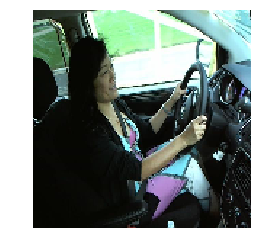

1. safe_driving: 99.306244%
2. talking_to_passanger: 0.654597%
3. texting_right: 0.036650%
4. talking_on_phone_left: 0.000892%
5. texting_left: 0.000836%


In [10]:
if __name__ == "__main__":
    
    # ----------STEP 1-----------
    extract_vgg16_features() #Computationally heavy step
    
    # ----------STEP 2-----------
    model = train_top_model()
    
    # ----------STEP 3-----------
    test_model(model)
    
    # ----------STEP 4-----------
    get_prediction_from_image("../../../dataset/split_data/test/c0/img_42043.jpg")